# Projekt Week 03 - Bike Share Demand

## Buisness Goal

#### Predict the total count of bikes rented during each hour 

## Import

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (15, 8)

## Read Data

In [2]:
data = pd.read_csv('data/bike-share-demand/train.csv', parse_dates=True, index_col=0)

In [3]:
data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
data.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


* *datetime* - hourly date + timestamp  
* *season* -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* *holiday* - whether the day is considered a holiday
* *workingday* - whether the day is neither a weekend nor holiday
* *weather* 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* *temp* - temperature in Celsius
* *atemp* - "feels like" temperature in Celsius
* *humidity* - relative humidity
* *windspeed* - wind speed
* *casual* - number of non-registered user rentals initiated
* *registered* - number of registered user rentals initiated
* *count* - number of total rentals **(y value)**

In [5]:
### y-value = 'count' column

## Train-Test-Split

#### Test data is in seperate file test.csv 

## Custom Functions

In [6]:
# extract date features
def extract_date_info(df):
    
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['weekday'] = df.index.day_name()
    df['hour'] = df.index.hour

In [7]:
# Outlier detection

# https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm
def m_z_score(series):
    z_score = (0.6745*(series-series.median()))/series.mad()
    return z_score

def detect_outlier(series, threshold=3.5):
    outliers = series[m_z_score(series) > threshold]
    return outliers

## Benchmark Model

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, r2_score

In [9]:
X_train = data.drop(['count', 'casual', 'registered'], axis=1)
y_train = data['count']

### Linear Regression

In [10]:
lr_base = LinearRegression().fit(X_train, np.log1p(y_train))

print("Coefficients:", lr_base.coef_)
print("Intercept   :", lr_base.intercept_)
print()
print(f'R2-Score: {round(r2_score(np.log1p(y_train), lr_base.predict(X_train)),3)}')
print(f'RSMLE-Score: {round(np.sqrt(mean_squared_log_error(y_train, np.expm1(lr_base.predict(X_train)))),3)}')

Coefficients: [ 0.18938095 -0.0963132  -0.09554135  0.11743638  0.00536533  0.04939067
 -0.02599913  0.00868621]
Intercept   : 4.238817170425407

R2-Score: 0.263
RSMLE-Score: 1.218


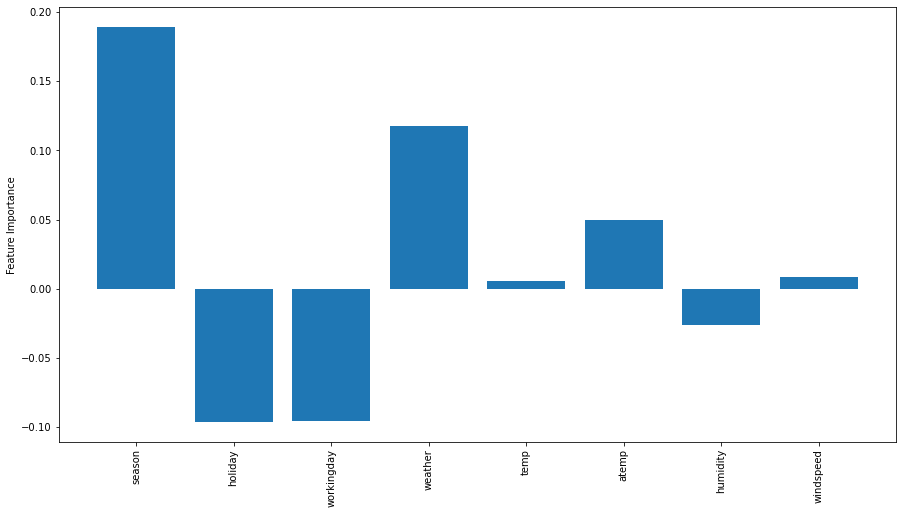

In [11]:
plt.bar(X_train.columns, lr_base.coef_)
plt.xticks(rotation=90)
plt.ylabel('Feature Importance')
#plt.savefig('baseline.png')
plt.show()

### Random Forest

In [12]:
rdf_base = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=5, min_samples_leaf=1)
rdf_base.fit(X_train, np.log1p(y_train))

print(f'R2-Score: {round(r2_score(np.log1p(y_train), rdf_base.predict(X_train)),3)}')
print(f'RSMLE-Score: {round(np.sqrt(mean_squared_log_error(y_train, np.expm1(rdf_base.predict(X_train)))),3)}')

R2-Score: 0.312
RSMLE-Score: 1.178


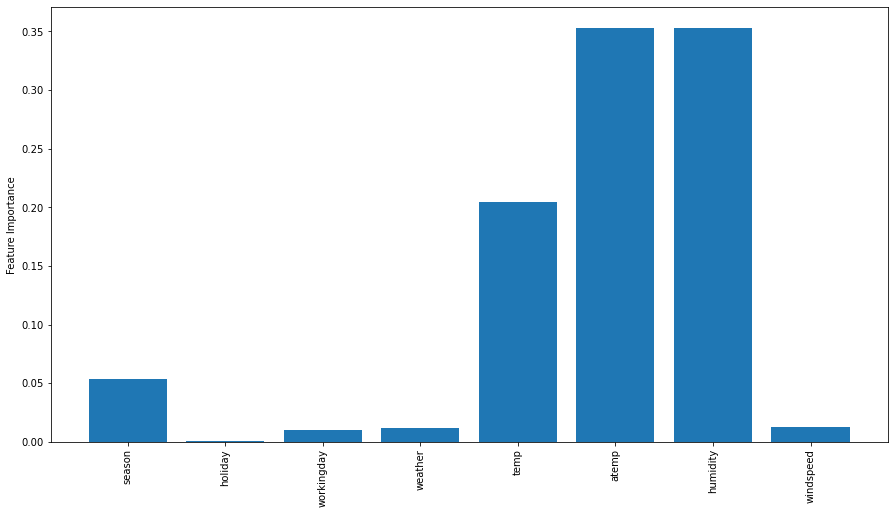

In [13]:
plt.bar(X_train.columns, rdf_base.feature_importances_)
plt.xticks(rotation=90)
plt.ylabel('Feature Importance')
#plt.savefig('baseline.png')
plt.show()

## Feature Engineering

In [14]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, StandardScaler, MinMaxScaler 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from feature_names import get_feature_names

In [15]:
data_feat = data.copy()

In [16]:
extract_date_info(data_feat)

In [17]:
data_feat.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,weekday,hour
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,1,Saturday,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,Saturday,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,1,Saturday,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,1,Saturday,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,1,Saturday,4


### Remove outliers

In [18]:
data_feat.drop(detect_outlier(data_feat['count']).index, inplace=True) # y-data (count) outlier

In [19]:
data_feat.drop(detect_outlier(data_feat['windspeed']).index, inplace=True) ## windspeed outlier

In [20]:
# drop outlier weather data point of category 4
#data_feat.drop(data_feat[data_feat['weather'] == 4].index, inplace=True) 

### Fill missing values

In [21]:
data_feat['humidity'].replace(to_replace=0, 
                               value=np.mean([data_feat.loc['2011-03-09']['humidity'].mean(), 
                                              data_feat.loc['2011-03-11']['humidity'].mean()]), 
                               inplace=True)

### Split X and Y

In [22]:
y_train_feat = data_feat['count']
X_train_feat = data_feat.drop(['count', 'casual', 'registered'], axis=1)

### Transform y

In [23]:
y_train_feat_log = np.log1p(y_train_feat)

In [24]:
#X_train_feat['hr_sin'] = np.sin(X_train_feat.index.hour*(2.*np.pi/24))
#X_train_feat['hr_cos'] = np.cos(X_train_feat.index.hour*(2.*np.pi/24))
#X_train['mnth_sin'] = np.sin((X_train.month-1)*(2.*np.pi/12))
#X_train['mnth_cos'] = np.cos((X_train.month-1)*(2.*np.pi/12))
#X_train['wkd_sin'] = np.sin((X_train.index.weekday)*(2.*np.pi/7))
#X_train['wkd_cos'] = np.cos((X_train.index.weekday)*(2.*np.pi/7))

### Pipelines and ColumnTransformer

In [25]:
pipeline_bin5_scale = Pipeline(steps=[('bin10', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')), ('scale', MinMaxScaler())])
pipeline_bin10_scale = Pipeline(steps=[('bin10', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')), ('scale', MinMaxScaler())])

In [26]:
feature_eng_trees = ColumnTransformer([
    ('pass', 'passthrough', ['humidity', 'atemp', 'windspeed', 'workingday']), 
    ('encode', OneHotEncoder(drop='first'), ['month','hour','weather', 'weekday']),
    #('bins_5 and scale', pipeline_bin5_scale, ['windspeed', 'humidity']),
    #('bins_10 and scale', pipeline_bin10_scale, ['temp']),
    #('scale and standarise', pipeline_scale_std , ['windspeed', 'humidity', 'temp'])
]) 

In [27]:
feature_eng_lr = ColumnTransformer([
    ('pass', 'passthrough', ['humidity', 'atemp']), 
    ('encode', OneHotEncoder(drop='first'), ['month','hour','weather', 'weekday']),
    #('bins_5 and scale', pipeline_bin5_scale, ['windspeed', 'humidity']),
    #('bins_10 and scale', pipeline_bin10_scale, ['temp']),
    #('scale and standarise', pipeline_scale_std , ['windspeed', 'humidity', 'temp'])
]) 

## Train Model & Cross-Validation

In [28]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import make_scorer

In [29]:
def rsmle_scorer(y_true, y_pred):
    RSMLE = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))
    return RSMLE

In [30]:
splits = ShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 10)
splits.get_n_splits(X_train, y_train)

5

### Linear Regression

In [31]:
feature_eng_matrix_lr = feature_eng_lr.fit_transform(X_train_feat)

In [32]:
lr = LinearRegression().fit(feature_eng_matrix_lr, y_train_feat_log)

print("Coefficients:", lr.coef_)
print("Intercept   :", lr.intercept_)
print()
print(f'R2-Score: {round(r2_score(np.log1p(y_train_feat), lr.predict(feature_eng_matrix_lr)),3)}')
print(f'RSMLE-Score: {round(np.sqrt(mean_squared_log_error(y_train_feat, np.expm1(lr.predict(feature_eng_matrix_lr)))),3)}')

Coefficients: [-5.35119512e-03  3.27346967e-02  1.39899095e-01  1.99469835e-01
  3.64058566e-01  5.91133627e-01  4.94221024e-01  3.77881457e-01
  4.27325600e-01  5.47978853e-01  6.89840202e-01  6.77812276e-01
  6.58762308e-01 -5.96982880e-01 -1.08581544e+00 -1.57144402e+00
 -1.83252439e+00 -8.74077477e-01  3.04687956e-01  1.26627288e+00
  1.87763838e+00  1.52947863e+00  1.18756438e+00  1.28841946e+00
  1.45918772e+00  1.42054047e+00  1.33035023e+00  1.38785883e+00
  1.65177239e+00  2.06094544e+00  1.99023944e+00  1.72273717e+00
  1.43667495e+00  1.19289546e+00  9.60530407e-01  5.76145781e-01
 -1.71088032e-02 -4.86652682e-01  2.94556945e-01 -1.54502278e-01
 -4.91400361e-04 -8.63442169e-02 -9.37326815e-02 -1.71041184e-01
 -1.51761134e-01]
Intercept   : 3.0638242587883084

R2-Score: 0.806
RSMLE-Score: 0.625


In [33]:
cv_lr = cross_val_score(estimator=lr, 
                X=feature_eng_matrix_lr, 
                y=y_train_feat,
                scoring= make_scorer(rsmle_scorer, greater_is_better=True),
                cv=splits)

<ipython-input-29-4c4d5c0a3a1a>:2: RuntimeWarning: invalid value encountered in log1p
  RSMLE = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))
<ipython-input-29-4c4d5c0a3a1a>:2: RuntimeWarning: invalid value encountered in log1p
  RSMLE = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))
<ipython-input-29-4c4d5c0a3a1a>:2: RuntimeWarning: invalid value encountered in log1p
  RSMLE = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))
<ipython-input-29-4c4d5c0a3a1a>:2: RuntimeWarning: invalid value encountered in log1p
  RSMLE = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))
<ipython-input-29-4c4d5c0a3a1a>:2: RuntimeWarning: invalid value encountered in log1p
  RSMLE = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))


In [34]:
print(f'CV-RSMLE-Score: {cv_lr}')

CV-RSMLE-Score: [0.86549334 0.8339284  0.86156708 0.82246101 0.84845894]


In [35]:
feature = get_feature_names(feature_eng_lr)

In [36]:
coeff = lr.coef_

Text(0, 0.5, 'Feature Importance')

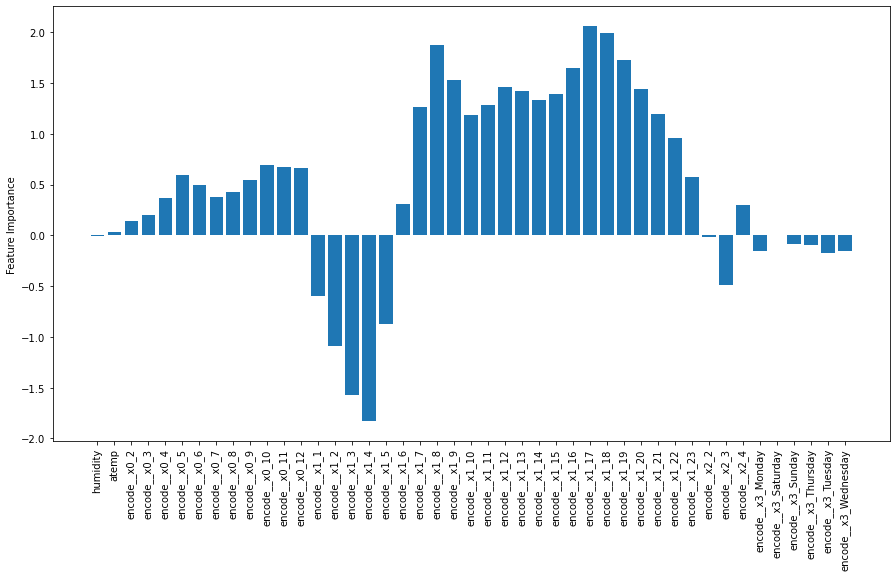

In [37]:
plt.bar(feature, coeff)
#plt.xlabel(xlabel = labels)
plt.xticks(rotation=90)
plt.ylabel('Feature Importance')

### Random Forest

In [38]:
feature_eng_matrix_trees = feature_eng_trees.fit_transform(X_train_feat)

In [39]:
rdf = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=5, min_samples_leaf=1)
rdf.fit(feature_eng_matrix_trees, y_train_feat_log)

print(f'R2-Score: {round(r2_score(np.log1p(y_train_feat), rdf.predict(feature_eng_matrix_trees)),3)}')
print(f'RSMLE-Score: {round(np.sqrt(mean_squared_log_error(y_train_feat, np.expm1(rdf.predict(feature_eng_matrix_trees)))),3)}')

R2-Score: 0.888
RSMLE-Score: 0.474


In [40]:
cv_rdf = cross_val_score(estimator=rdf, 
                X=feature_eng_matrix_trees, 
                y=y_train_feat,
                scoring= make_scorer(rsmle_scorer, greater_is_better=True),
                cv=splits)

In [41]:
print(f'CV-RSMLE-Score: {cv_rdf}')

CV-RSMLE-Score: [0.77455731 0.74399227 0.7457691  0.76802285 0.71308817]


### Gradient Boosting

In [42]:
from catboost import CatBoostRegressor

In [43]:
gdb = CatBoostRegressor(iterations=200, learning_rate=0.5, depth=4, silent=True)
gdb.fit(feature_eng_matrix_trees, y_train_feat_log)

print(f'R2-Score: {round(r2_score(np.log1p(y_train_feat), gdb.predict(feature_eng_matrix_trees)),3)}')
print(f'RSMLE-Score: {round(rsmle_scorer(y_train_feat, np.expm1(gdb.predict(feature_eng_matrix_trees))),3)}')

R2-Score: 0.932
RSMLE-Score: 0.369


In [44]:
cv_gdb = cross_val_score(estimator=gdb, 
                X=feature_eng_matrix_trees, 
                y=y_train_feat,
                scoring= make_scorer(rsmle_scorer, greater_is_better=True),
                cv=splits)

<ipython-input-29-4c4d5c0a3a1a>:2: RuntimeWarning: invalid value encountered in log1p
  RSMLE = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))


In [45]:
print(f'CV-RSMLE-Score: {cv_gdb}')

CV-RSMLE-Score: [0.60129357 0.63418782 0.6484345  0.65738858 0.61751124]


## Hyperparameter Optimisation - needs more work, doesn't give good parameter

### Random Forest

In [46]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from pprint import pprint

grid = GridSearchCV(rdf,
        param_grid={'n_estimators': [100, 200], 'max_depth':[5,10,15], 'min_samples_split':[5]},
        scoring='r2',
        n_jobs=1,
        cv=splits
        )

grid.fit(feature_eng_matrix_trees, y_train_feat_log)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10, test_size=0.2, train_size=None),
             estimator=RandomForestRegressor(max_depth=15, min_samples_split=5),
             n_jobs=1,
             param_grid={'max_depth': [5, 10, 15], 'min_samples_split': [5],
                         'n_estimators': [100, 200]},
             scoring='r2')

In [47]:
#print("all scores      :")
#pprint(grid.cv_results_)

print("\nbest score      :", grid.best_score_)
print("\nbest estimator     :", grid.best_params_)


best score      : 0.8462106581364859

best estimator     : {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}


### Gradient Boost 

In [48]:
grid_gdb = GridSearchCV(gdb,
        param_grid={'iterations': [50, 100, 200], 'learning_rate':[0.5, 1], 'depth':[5,6,7]},
        scoring='r2',
        n_jobs=1,
        cv=splits
        )

grid_gdb.fit(feature_eng_matrix_trees, y_train_feat_log)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10, test_size=0.2, train_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fbaa5d8c550>,
             n_jobs=1,
             param_grid={'depth': [5, 6, 7], 'iterations': [50, 100, 200],
                         'learning_rate': [0.5, 1]},
             scoring='r2')

In [49]:
#print("all scores      :")
#pprint(grid.cv_results_)

print("\nbest score      :", grid_gdb.best_score_)
print("\nbest estimator     :", grid_gdb.best_params_)


best score      : 0.9219132698715123

best estimator     : {'depth': 7, 'iterations': 200, 'learning_rate': 0.5}


## Calculate test score = Submission to Kaggle

In [50]:
test = pd.read_csv('data/bike-share-demand/test.csv', parse_dates=True, index_col=0)

In [51]:
extract_date_info(test)

In [52]:
# feature set for linear regression - 'feature_eng_lf' and 'feature_eng_trees'
test_matrix = feature_eng_trees.transform(test) 

In [53]:
y_test = rdf.predict(test_matrix)

In [54]:
y_test_df = pd.DataFrame(np.expm1(y_test), index=test.index, columns=['count'])

In [55]:
y_test_df[y_test_df['count'] < 0]

,count
datetime,


In [56]:
y_test_df.to_csv('data/bike-share-demand/prediction_rdf.csv')

## What I learned

* Linear Regression works better on a few features (binning of numerical features seems not help prediction)
* Hour overpowers all other features in Linear Regression

* Trees pick up more nuances in the data and lead to better prediction 
* but suffer from overprediction keep depth shallow and/or min_sample_split at 5 (when only using a few features)
* Gradient Boost seems to also better predict with more features, shallow depth (4) - *overfitting*, learning_rate at 0.5, and high number of iterations > 100 -> but needs more exploration
* strangly Gradient Boost gives me negative target values for depth > 5 - *maybe also result of overfitting*